Finding repeated DIA Sources
============================

This notebook searches for DIA source detections that have the same pixel position in images of unrelated fields. These are most likely caused by CCD defects, although one could imagine more exotic sources as well.

The data used are from four different fields. We use the DIA source catalog from a single visit to each field. For each field, we compute the crossmatch in pixel coordinates between that field's DIA sources and each other field, excluding fields that had already been processed to avoid double counting. We then take the histogram of separations between sources. The resulting histograms from all fields were summed. The same process was repeated with a catalog that had the positions of sources randomized, thus providing a estimate of the resulting histogram in the uncorrelated case.

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import MySQLdb

import matplotlib.transforms as transforms
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.table import Table

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (10.0, 6.5)
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelcolor'] = "#000000"

In [2]:
db = MySQLdb.connect(db="decam_rescaled", read_default_file="~/.my.cnf")
cursor = db.cursor()

Since all of this is in pixel coordinates, we can work ccd-by-ccd. Download the data for all visits from a single chip as an example.

In [3]:
cursor.execute("SELECT base_TransformedCentroid_x, base_TransformedCentroid_y, visitid "
               "FROM diasource as dia "
               "JOIN force_source as fs ON id=objectId "
               "WHERE (visitid=197367 or visitid=197388 or visitid=197400 or visitid=199021) AND ccdnum=10 AND "
               "dia.classification_dipole=0 AND "
               "((fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux)/"
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) > 5)"
               )
rows = cursor.fetchall()
centroid_table = Table(rows=rows, names=("centroid_x", "centroid_y", "visitid"))

Plot the pixel coordinates, and also print out the coordinates close matches for visual inspection.

(197367, 22)
(197388, 27)
(197400, 37)
(199021, 73)
10
[(1713.9476318359375, 3116.8193359375, 197367), (712.891845703125, 3237.97705078125, 197367), (1829.801513671875, 3325.94189453125, 197367), (1805.881591796875, 3468.91259765625, 197367), (1620.580322265625, 3560.736083984375, 197367), (713.16400146484375, 3237.969970703125, 197400), (1713.9146728515625, 3116.81005859375, 199021), (1829.384033203125, 3325.226806640625, 199021), (1805.879150390625, 3468.8984375, 199021), (1620.3333740234375, 3560.74951171875, 199021)]


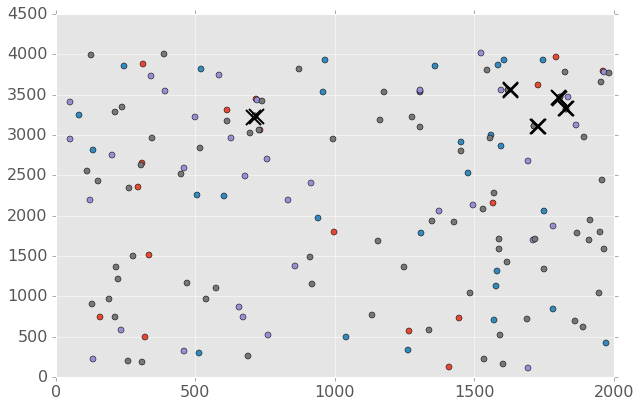

In [4]:
for visitid in np.unique(centroid_table['visitid']):
    sel, = np.where(centroid_table['visitid'] == visitid)
    plt.plot(centroid_table['centroid_x'][sel], centroid_table['centroid_y'][sel], 'o')
    print(visitid, len(sel))
    
source_coords = SkyCoord(x=centroid_table['centroid_x'], y=centroid_table['centroid_y'], z=0, unit="kpc",
                           representation="cartesian")
idx, _, match_dist = source_coords.match_to_catalog_3d(source_coords, nthneighbor=2)
sel, = np.where(match_dist/u.kpc < 2)
print len(sel)
plt.plot(centroid_table['centroid_x'][sel] + np.random.randn(len(sel))*10,
         centroid_table['centroid_y'][sel] + np.random.randn(len(sel))*10, 'kx', mew=2, ms=15)
print zip(centroid_table['centroid_x'][sel], centroid_table['centroid_y'][sel], centroid_table['visitid'][sel])

Crossmatch and Histogram
------------------------
This function defines the crossmatching and binning operation on a single CCD.

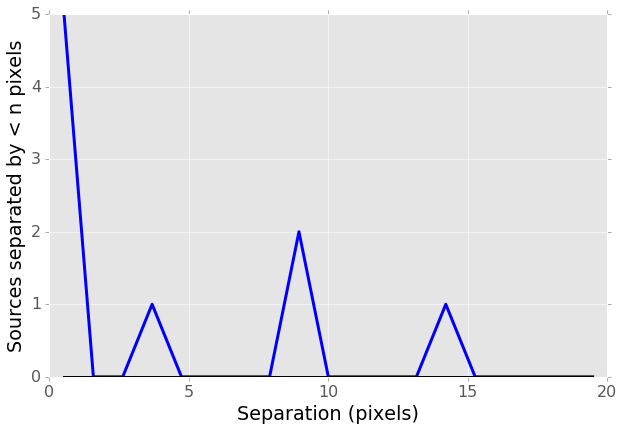

In [5]:
def separation_histograms(table, dist_bins, use_same_visit=False):
    source_coords = SkyCoord(x=table['centroid_x'], y=table['centroid_y'], z=0, unit="kpc",
                               representation="cartesian")
    random_coords = SkyCoord(x=np.random.rand(len(table))*2000, y=np.random.rand(len(table))*4000,z=0,
                             unit="kpc", representation="cartesian")



    H = np.zeros(len(dist_bins) - 1)
    H_random = np.zeros(len(dist_bins) - 1)
    unique_visits = np.unique(table['visitid'])
    measured_visits = 0
    completed_visits = []
    for visitid in unique_visits:
        sel_this_visit, = np.where(table['visitid'] == visitid)
        if use_same_visit:
            target_visits = [visitid]
        else:
            target_visits = filter(lambda x: (x != visitid) and (x not in completed_visits), unique_visits)

        for other_visitid in target_visits:
            sel_other_visit, = np.where(table['visitid'] == other_visitid)
            nthneighbor = 2 if use_same_visit else 1
            measured_visits += 1

            _, _, match_dist = source_coords[sel_this_visit].match_to_catalog_3d(source_coords[sel_other_visit],
                                                                                nthneighbor=nthneighbor)
            this_H, _ = np.histogram(match_dist/u.kpc, bins=dist_bins)
            H += this_H

            _, _, match_dist = random_coords[sel_this_visit].match_to_catalog_3d(random_coords[sel_other_visit],
                                                                                nthneighbor=nthneighbor)
            this_H_rand, _ = np.histogram(match_dist/u.kpc, bins=dist_bins)
            H_random += this_H_rand
        completed_visits.append(visitid)

    return H, H_random

dist_bins = np.linspace(0, 20, 20)
bin_centers = 0.5*(dist_bins[1:] + dist_bins[:-1])

H, H_random = separation_histograms(centroid_table, dist_bins)

plt.plot(bin_centers, H, 'b-', lw=3)
plt.plot(bin_centers, H_random, 'k-', lw=2)
plt.ylabel("Sources separated by < n pixels")
plt.xlabel("Separation (pixels)")

Looping over many CCDs now. Print out any CCDs with significant numbers of close pairs.

In [6]:
dist_bins = np.linspace(0, 20, 20)
bin_centers = 0.5*(dist_bins[1:] + dist_bins[:-1])

ratios = []
H_total = np.zeros(len(dist_bins) - 1)
H_total_random = np.zeros(len(dist_bins) - 1)
for ccdnum in range(5,30):
    cursor.execute("SELECT base_TransformedCentroid_x, base_TransformedCentroid_y, visitid "
               "FROM diasource as dia "
               "JOIN force_source as fs ON id=objectId "
               "WHERE (visitid=197367 or visitid=197388 or visitid=197400 or visitid=199021) AND ccdnum=%s AND "
               "dia.classification_dipole=0 AND "
               "((fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux)/"
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) > 5)",
               (ccdnum,))
    rows = cursor.fetchall()
    ccd_centroid_table = Table(rows=rows, names=("centroid_x", "centroid_y", "visitid"))

    H, H_random = separation_histograms(ccd_centroid_table, dist_bins)
    if H[0] > 3:
        print "ccd {:d}, H[0]: {:f}".format(ccdnum, H[0])

#    plt.plot(bin_centers, np.cumsum(H), 'b-', lw=3)
#    plt.plot(bin_centers, np.cumsum(H_random), 'k-', lw=2)
#    plt.plot(bin_centers, np.cumsum(H)/np.cumsum(H_random), 'k-', lw=2)
#    plt.plot(bin_centers, H/H_random, 'k-', lw=2, alpha=0.3)
#    ratios.append(H/H_random)
    H_total += H
    H_total_random += H_random



ccd 10, H[0]: 5.000000
ccd 23, H[0]: 7.000000


Crossmatch Result
=================

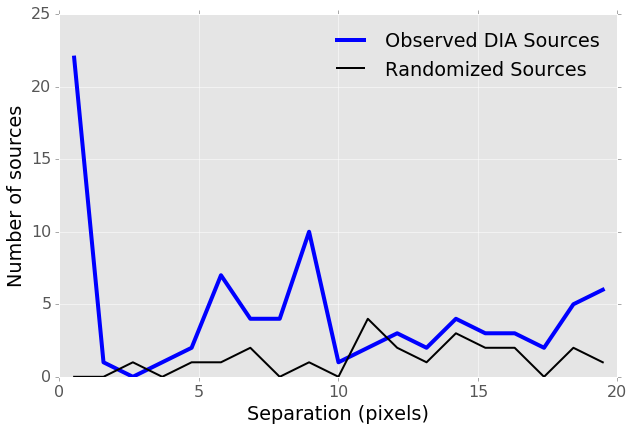

In [7]:
plt.plot(bin_centers, H_total, 'b-', lw=4, label="Observed DIA Sources")
plt.plot(bin_centers, H_total_random, 'k-', lw=2, label="Randomized Sources")
plt.xlabel("Separation (pixels)")
plt.ylabel("Number of sources")
plt.legend(frameon=False)

The most interesting result here is the very first bin, showing the number of DIA sources between visits that match to within a pixel. This is ~23 sources over 25 CCDS and four visits. Each CCD is 0.043 square degrees, so $23/(25\times4\times0.043) = 5.3$ per square degree. This is somewhat dependent on how one wants to count an effect that appears between pairs of images, but it seems like an appropriate order of magnitude.

Visual inspection of the sources show that many are near CCD defects or artifacts where the stack has performed an interpolation over bad data. This could result in DIA sources if this masking is incomplete, or possibly by some interaction between the interpolation process and the convolution/detection process in image differencing. Further diagnosis would required detailed work on individual sources, but the overall number density of these sources seems sufficiently low as to not be a serious issue.

Debugging code
==============

Code below here is meant for debugging, etc.

In [8]:
cursor.execute("DESCRIBE force_source;")
cursor.fetchall()

(('objectId', 'bigint(20)', 'NO', '', None, ''),
 ('coord_ra', 'double', 'YES', '', None, ''),
 ('coord_dec', 'double', 'YES', '', None, ''),
 ('parentObjectId', 'bigint(20)', 'NO', '', None, ''),
 ('base_TransformedCentroid_x', 'double', 'YES', '', None, ''),
 ('base_TransformedCentroid_y', 'double', 'YES', '', None, ''),
 ('base_TransformedCentroid_flag', 'bit(1)', 'NO', '', None, ''),
 ('base_PsfFlux_flux', 'double', 'YES', '', None, ''),
 ('base_PsfFlux_fluxSigma', 'double', 'YES', '', None, ''),
 ('base_PsfFlux_flag', 'bit(1)', 'NO', '', None, ''),
 ('base_PsfFlux_flag_noGoodPixels', 'bit(1)', 'NO', '', None, ''),
 ('base_PsfFlux_flag_edge', 'bit(1)', 'NO', '', None, ''),
 ('base_PsfFlux_apCorr', 'double', 'YES', '', None, ''),
 ('base_PsfFlux_apCorrSigma', 'double', 'YES', '', None, ''),
 ('base_PsfFlux_flag_apCorr', 'bit(1)', 'NO', '', None, ''),
 ('classification_dipole', 'int(11)', 'NO', '', None, ''),
 ('template_base_PsfFlux_flux', 'double', 'YES', '', None, ''),
 ('template

In [9]:
same_visit_ratios = []
for ccdnum in range(5, 30):
    cursor.execute("SELECT base_TransformedCentroid_x, base_TransformedCentroid_y, visitid "
               "FROM diasource as dia "
               "JOIN force_source as fs ON id=objectId "
               "WHERE (visitid=197367 or visitid=197388 or visitid=197400 or visitid=198668) AND ccdnum=%s AND "
               "dia.classification_dipole=0 AND "
               "((fs.base_PsfFlux_flux - fs.template_base_PsfFlux_flux)/"
               "SQRT(POW(fs.base_PsfFlux_fluxSigma,2) + POW(fs.template_base_PsfFlux_fluxSigma,2)) > 5)",
               (ccdnum,))
    rows = cursor.fetchall()
    ccd_centroid_table = Table(rows=rows, names=("centroid_x", "centroid_y", "visitid"))

    H, H_random = separation_histograms(ccd_centroid_table, dist_bins, use_same_visit=True)

    same_visit_ratios.append(H/H_random)

/Users/ctslater/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: divide by zero encountered in divide
/Users/ctslater/.local/lib/python2.7/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in divide


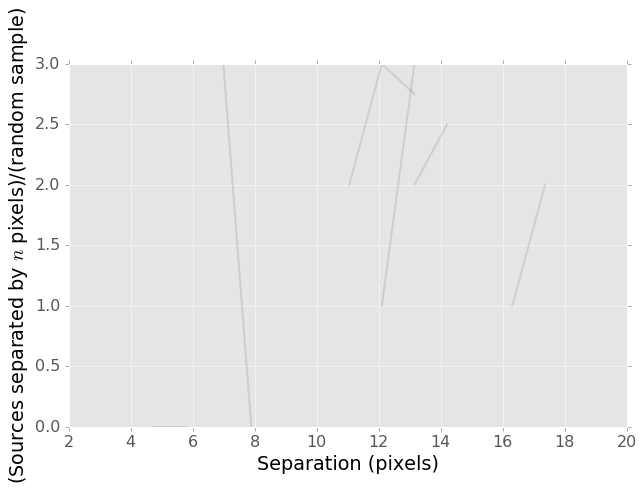

In [10]:
for ratio in same_visit_ratios:
    plt.plot(bin_centers, ratio, 'k-', lw=2, alpha=0.1)
plt.plot(bin_centers, np.mean(np.vstack(filter(lambda x: ~isinf(x).any(), same_visit_ratios)), axis=0), 'k-', lw=4)
plt.ylim(0, 3)
plt.ylabel(r"(Sources separated by $n$ pixels)/(random sample)")
plt.xlabel("Separation (pixels)")